In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import matplotlib.dates as mdates
import sklearn.metrics as sm
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV

from statsmodels.tsa.stattools import adfuller
from sklearn.feature_selection import RFE

%matplotlib inline

In [98]:
# Collect and clean the data
original_data = pd.read_csv('google-stock-dataset.csv')
original_data.set_index("Date", inplace=True)
original_data

,Unnamed: 0,Price,High,Low,Close,Volume,Adj Close
Date,,,,,,,
2013-04-15,0,19.67,19.94,19.44,19.57,98025876,19.57
2013-04-16,1,19.68,19.92,19.62,19.85,69610320,19.85
2013-04-17,2,19.69,19.79,19.47,19.58,81398520,19.58
2013-04-18,3,19.65,19.66,19.05,19.17,132767100,19.17
2013-04-19,4,19.25,20.11,19.18,20.02,231895872,20.02
...,...,...,...,...,...,...,...
2023-03-27,2505,104.62,104.76,101.93,102.46,31120900,102.46
2023-03-28,2506,102.44,102.45,99.74,101.03,32057900,101.03
2023-03-29,2507,102.28,102.49,100.65,101.39,28779600,101.39


In [74]:
# Check for empty value
original_data.isna().sum()

Unnamed: 0    0
Price         0
High          0
Low           0
Close         0
Volume        0
Adj Close     0
dtype: int64

(array([-500.,    0.,  500., 1000., 1500., 2000., 2500., 3000.]),
 [Text(-500.0, 0, '2021-04-08'),
  Text(0.0, 0, '2013-04-15'),
  Text(500.0, 0, '2015-04-09'),
  Text(1000.0, 0, '2017-04-03'),
  Text(1500.0, 0, '2019-03-29'),
  Text(2000.0, 0, '2021-03-24'),
  Text(2500.0, 0, '2023-03-20'),
  Text(3000.0, 0, '')])

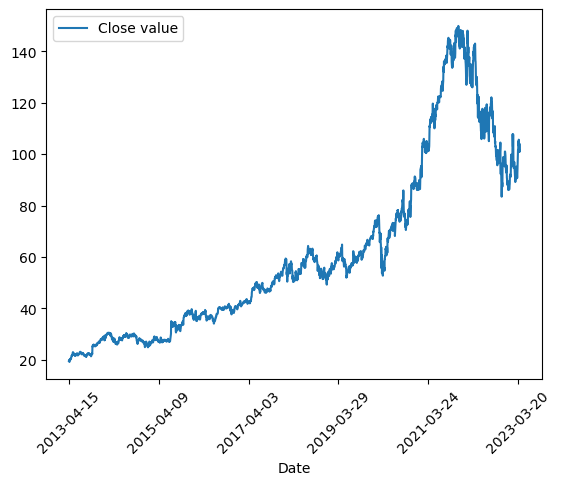

In [121]:
# Show the data visually
original_data.plot(y="Close")
plt.legend(['Close value'])
plt.xticks(rotation=45)

array([<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>,
       <AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>,
       <AxesSubplot:xlabel='Date'>], dtype=object)

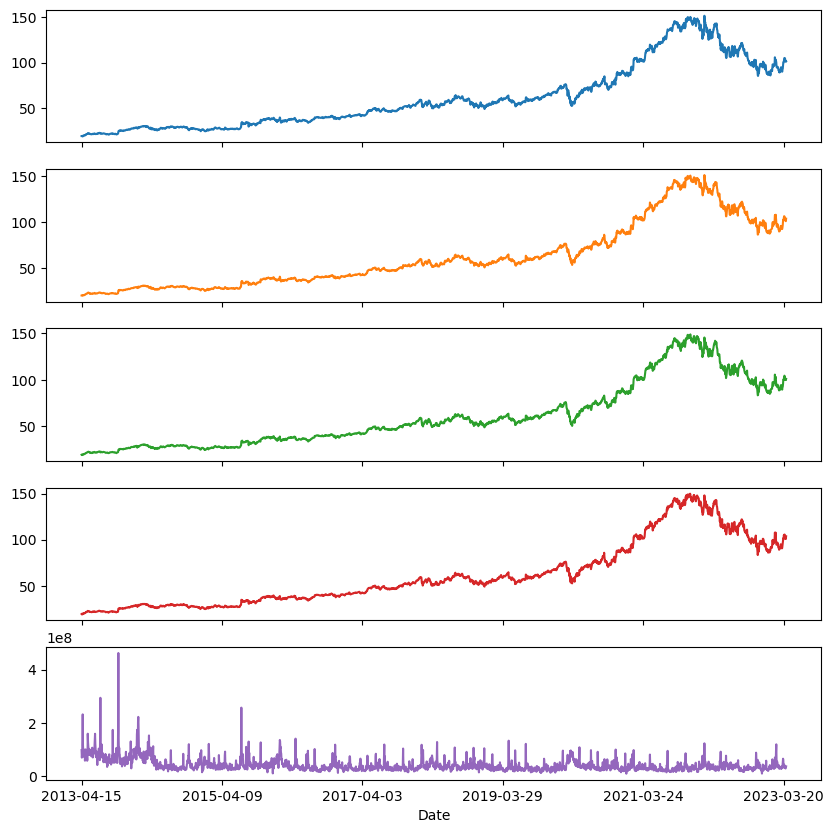

In [164]:
original_data[['Price', 'High', 'Low', 'Close', 'Volume']].plot(subplots=True, figsize=(10, 10), xticks=None, kind='line', legend=None)

Close        AxesSubplot(0.125,0.11;0.352273x0.77)
Volume    AxesSubplot(0.547727,0.11;0.352273x0.77)
dtype: object

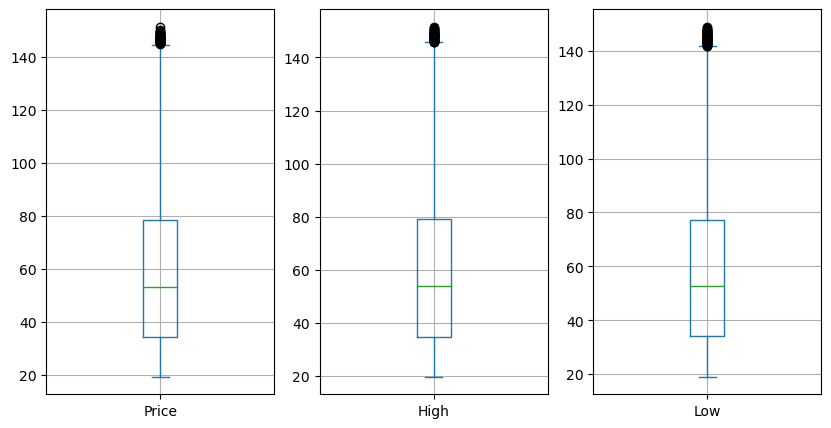

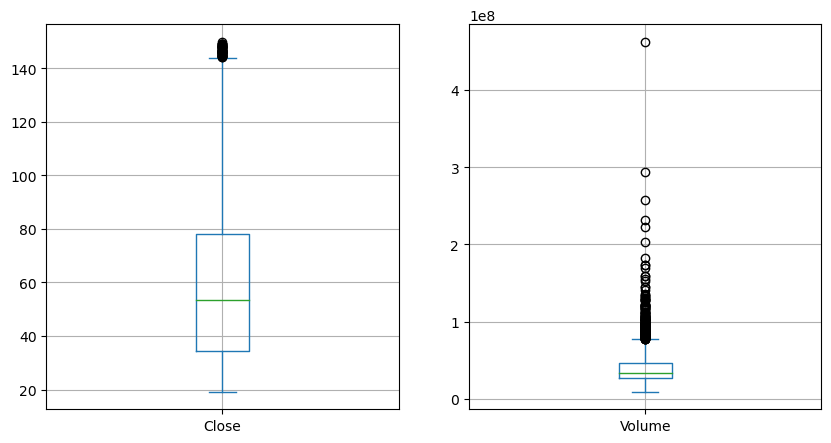

In [165]:
# Show outliner
original_data[['Price', 'High', 'Low']].plot(subplots=True, figsize=(10, 5), xticks=None, kind='box', grid=True)
original_data[['Close', 'Volume']].plot(subplots=True, figsize=(10, 5), xticks=None, kind='box', grid=True)

<AxesSubplot:>

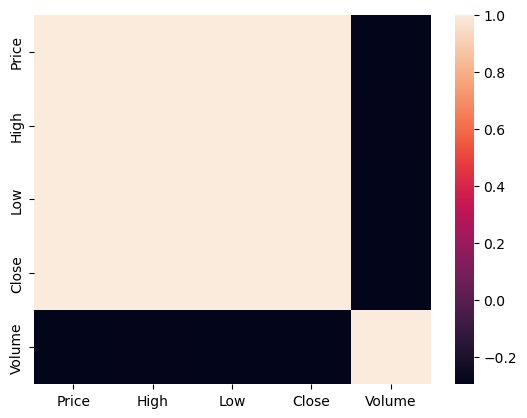

In [174]:
sns.heatmap(original_data[['Price', 'High', 'Low', 'Close', 'Volume']].corr(), robust=True)

In [119]:
#### PREPROCESSING ####
original_data = original_data.dropna() # Drop missing data

# x_data = original_data.iloc[:, original_data.columns != 'Volume'].values # x_data.shape = (2510, 6)
x_data = original_data.drop(['Close', 'Adj Close'], axis=1).values
y_data = original_data['Close'].values # y_data.shape = (2510, )
# Divide into train and test datasets
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.18, random_state=0, shuffle=False)
# Scaling the features
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

y_data

array([ 19.57,  19.85,  19.58, ..., 101.39, 100.89, 103.73])

In [120]:
# Create the model
model = RandomForestRegressor(n_estimators=300, random_state=42, min_samples_split=2, min_samples_leaf=1, max_depth=10, bootstrap=True, oob_score=True)

In [59]:
# grid_rf = {
# 'n_estimators': [20, 50, 100, 500, 1000],  
# 'max_depth': np.arange(1, 15, 1),  
# 'min_samples_split': [2, 10, 9], 
# 'min_samples_leaf': np.arange(1, 15, 2, dtype=int),  
# 'bootstrap': [True, False], 
# 'random_state': [1, 2, 30, 42]
# }
# rscv = RandomizedSearchCV(estimator=model, param_distributions=grid_rf, cv=3, n_jobs=-1, verbose=2, n_iter=200)
# rscv_fit = rscv.fit(x_train, y_train)
# best_parameters = rscv_fit.best_params_
# print(best_parameters)

In [60]:
# Train the model
model.fit(x_train_scaled, y_train) # Training the model

RandomForestRegressor(max_depth=10, n_estimators=500, random_state=42,
                      warm_start=True)

In [61]:
# Test the model
y_predict = model.predict(x_test_scaled)
print('The model score is:', model.score(x_test_scaled, y_predict))

The model score is: 1.0


In [62]:
# Make the prediction
# x-axis
x_dates = []
predicted_dates = original_data.index[x_train.shape[0]:]
for d in predicted_dates:
    x_dates.append(mdates.date2num(dt.datetime.strptime(d, '%Y-%m-%d')))

# y-axis
print('Actual value is:')
print(y_test)
print('The model predicts the last row or day to be:')
print(y_predict)

Actual value is:
[120.77 121.74 120.11 121.81 122.33 122.13 122.5  122.51 122.54 122.27
 122.09 122.44 125.26 126.19 126.47 125.04 125.52 126.98 127.34 128.24
 127.   126.97 124.58 126.21 127.55 128.42 133.01 134.04 131.9  136.09
 135.78 134.73 134.85 135.63 135.13 136.25 135.74 136.91 136.81 136.28
 137.19 137.73 138.31 136.66 135.45 135.68 137.43 140.04 141.26 142.08
 141.44 144.   144.59 144.7  145.22 143.29 143.74 144.28 143.69 143.54
 140.88 142.33 142.54 144.43 143.61 140.8  138.72 139.03 140.28 141.22
 142.21 141.07 135.83 134.35 133.68 136.54 133.66 136.02 137.57 139.23
 139.79 138.91 136.45 137.58 141.15 141.37 142.78 143.24 141.77 141.89
 137.57 137.45 139.31 146.22 145.85 148.05 143.5  145.43 146.6  148.27
 148.85 149.03 148.92 145.89 145.77 148.68 148.45 147.88 148.05 149.84
 148.93 146.3  145.78 146.12 142.18 145.53 141.9  141.05 142.97 142.
 143.15 147.27 148.19 147.64 148.   145.83 143.91 146.44 144.45 141.73
 141.61 143.47 146.41 146.92 147.91 146.69 146.65 146.2  144.8

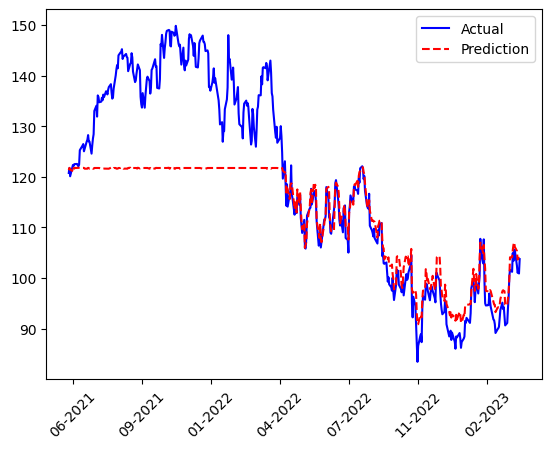

In [63]:
# Plot the test predictions
ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
plt.xticks(rotation=45)

plt.plot(x_dates, y_test, color='blue')
plt.plot(x_dates, y_predict, color='red', linestyle='--')
plt.gca().legend(('Actual', 'Prediction'))
plt.show()

In [64]:
# Link: https://stats.stackexchange.com/questions/235189/random-forest-regression-not-predicting-higher-than-training-data

In [65]:
# Performance evaludation
r2_score = sm.r2_score(y_test, y_predict)
print("(R^2) score:", round(r2_score, 4))

print(f'Train Score: {model.score(x_train_scaled, y_train) * 100:.2f}% and Test Score: {model.score(x_test_scaled, y_test) * 100:.2f}% using Random Tree Regressor.')

(R^2) score: 0.6013
Train Score: 99.99% and Test Score: 60.13% using Random Tree Regressor.
